#**HOMEWORK: BLUE BIKE TRIP DURATION PREDICTION (Total: / 15 points)**

Context: You have received some data from Blue Bikes (the Boston Bikesharing Service). They have asked you to provide a predictive model that can accurately predict how long a given bike rental will last, at the time the rental begins. The use case is that the bike share company wants to be able to predict how long a customer will have the bike in their possession, when they begin their retnal, in order to better manage operational efficiency across the bike network. Note that, when a customer initiates a bike rental, they enter the starting station ID and ending station ID into their mobile app.

# *Name: Gord*
# *Email: gburtch@bu.edu*

#*Import and Pre-process Data*

In [ ]:
!pip install haversine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [78]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import requests
import json
from haversine import haversine

bluebikes_train = pd.read_csv('https://raw.githubusercontent.com/gburtch/BA865-2023/main/Lecture%20Materials/C_Assignment/bluebikes_sample.csv')

# This function MUST return a pair of objects (predictors, labels, in that order) as numpy arrays.
def processData(data, makeDist='Haversine'):
    
    startmin = []
    for i in range(len(data)):
        startmin.append(int(data.loc[i,'starttime'].split(":")[0]))

    data['startmin'] = startmin
    
    data['usertype_bin'] = np.where(data['usertype']=='Subscriber',1,0)

    # This will throw away string variables.
    data = data.select_dtypes([np.number])
    
    # Here is how we could one-hot encode our data. 
    gender_onehot = utils.to_categorical(data['gender'])
    usertype_onehot = utils.to_categorical(data['usertype_bin'])

    ##### WARNING!
    # You will hopefully have realized that you need to be very careful with the features you choose to keep in your model!!
    # It's quite possible that you will encounter a new bike ID in the holdout sample that did not appear in the training data.
    # The same can happen with station IDs (though it's less likely). 
    # If this happens, it will produce an error when your code is executed, unless it's handled very carefully. 
    
    # Note that the one-hot IDs actually don't really help; they hurt performance!
    # My validation MAE gets to ~280 seconds if I don't use the dummies... 
    
    ### We can handle this by manually enforcing the training data's one-hot encoding scheme on the new data.
    ### See here for an explanation: https://stackoverflow.com/questions/50070201/pandas-handle-unseen-data-in-test.

    # Get the one-hot encoding representations from the original training data. 
    bike_onehot_train = pd.get_dummies(bluebikes_train['bikeid'])
    start_station_onehot_train = pd.get_dummies(bluebikes_train['start station id'])
    end_station_onehot_train = pd.get_dummies(bluebikes_train['end station id'])

    # Then apply the training data's one hot encodings to the new data. 
    # This will ignore any new values that haven't been seen before.
    # They will be coded as all 0's on our one-hot columns.
    # Of course, in training, we will be applying the sample's one hot encoding back to itself, so this won't matter until the holdout data comes. 
    bike_onehot = pd.get_dummies(data['bikeid']).reindex(columns=bike_onehot_train.columns, fill_value=0)
    start_station_onehot = pd.get_dummies(data['start station id']).reindex(columns=start_station_onehot_train.columns,fill_value=0)
    end_station_onehot = pd.get_dummies(data['end station id']).reindex(columns=end_station_onehot_train.columns,fill_value=0) 

    # If we are doing the distance construction, can either use Haversine, or try Open Street Maps.
    # I am doing some feature engineering here; use lat and lng to construct travel distances / durations. 
    if makeDist == 'Haversine':
        
        # First, let's get the list of unique pairs of start and end station coordinates. 
        # That way we don't need to duplicate effort.
        station_cols = data.loc[:,['start station latitude','start station longitude','end station latitude','end station longitude']]
        unique_pairs = station_cols.value_counts(ascending=True).reset_index(name='count').to_numpy()[:,0:4]
        
        # Put distances for unique pairs into a dictionary for lookups.
        # In theory we could do this for pairs in 'either' direction.
        dist = {}
        for i in range(len(unique_pairs)):
            dist[tuple(unique_pairs[i,:])] = haversine(station_cols.loc[i,['start station latitude','start station longitude']],
                                                       station_cols.loc[i,['end station latitude','end station longitude']])
            
        hav_dist = []
        for i in range(len(data)):
            index = data.loc[i,['start station latitude','start station longitude','end station latitude','end station longitude']]
            station_dist = dist[tuple(index)]
            hav_dist.append(station_dist)

        data['hav_dist'] = hav_dist
        predictors_cont = data[['start station latitude','start station longitude','end station latitude','end station longitude','birth year','startmin','hav_dist']].to_numpy()
        
    # Here we are doing trip duration queries using OpenStreetMaps
    elif makeDist == 'OSM':
        
        dist = []
        for i in range(len(data)):
    
            url = f"http://router.project-osrm.org/route/v1/car/{data.loc[i,['start station longitude']].to_numpy()[0]},{data.loc[i,['start station latitude']].to_numpy()[0]};{data.loc[i,['end station longitude']].to_numpy()[0]},{data.loc[i,['end station latitude']].to_numpy()[0]}?overview=false"
            # call the OSMR API
            r = requests.get(url)

            # then you load the response using the json libray
            # by default you get only one alternative so you access 0-th element of the `routes`
            routes = json.loads(r.content)
            shortest_duration = routes.get("routes")[0]['duration']
            dist.append(shortest_duration)
        
        data['travel_time'] = dist
        predictors_cont = data[['start station latitude','start station longitude','end station latitude','end station longitude','birth year','startmin','travel_time']].to_numpy()
    else:
        predictors_cont = data[['start station latitude','start station longitude','end station latitude','end station longitude','birth year','startmin']].to_numpy()

    # Pulling out continuous predictors, and 'normalizing' them.
    # You could also accomplish this with a BatchNormalization() layer in your model.
    predictors_cont = np.subtract(predictors_cont,np.mean(predictors_cont,axis=0).reshape(1,predictors_cont.shape[1]))
    predictors_cont = np.divide(predictors_cont,np.std(predictors_cont,axis=0).reshape(1,predictors_cont.shape[1]))

    # Putting everything back together.
    data = np.concatenate((data[['tripduration']].to_numpy(),predictors_cont,usertype_onehot,gender_onehot,bike_onehot,start_station_onehot,end_station_onehot),axis=1)
    
    # Create the labels vector and the matrix of predictors.
    labels = data[:,0]
    predictors = data[:,1:]
    
    train_labels = labels
    train_predictors = predictors

    return train_predictors, train_labels


#*Specify Your Neural Network Architecture, Process Your Sample*

Calling the data pre-processing function on the sample.

In [80]:
import warnings
warnings.filterwarnings('ignore')

### Note: using OSM as the distance will be slow because it'll make API calls for every observation to get the values; Haversine is quick. 

predictors, labels = processData(bluebikes_train,makeDist="Haversine")

Specifying my Neural Network's structure.

In [81]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(32, activation="relu"),
        layers.BatchNormalization(),
        layers.Dense(1)
    ])
    model.compile(optimizer="rmsprop", loss="mae", metrics=["mse"])
    return model

#*Train Your Neural Network Here*

In [82]:
folds = 2
num_val_samples = len(predictors) // folds # floor division (i.e., round down to nearest integer.)
num_epochs = 100
batch_sizes = 64
all_train_mae_histories, all_val_mae_histories = [],[]  

for i in range(folds): # the folds are going to be indexed 0 through 3 if k = 4
    print("Processing fold #:",i)
    
    val_data = predictors[i * num_val_samples: (i + 1) * num_val_samples] 
    val_targets = labels[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [predictors[:i * num_val_samples],
         predictors[(i + 1) * num_val_samples:]],
        axis=0)
    
    partial_train_targets = np.concatenate(
        [labels[:i * num_val_samples],
         labels[(i + 1) * num_val_samples:]],
        axis=0)
    
    model = build_model()

    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=batch_sizes)
    
    train_mae_history = history.history['loss']
    val_mae_history = history.history['val_loss']

    all_train_mae_histories.append(train_mae_history)
    all_val_mae_histories.append(val_mae_history)

average_train_mae_history = [np.mean([x[i] for x in all_train_mae_histories]) for i in range(num_epochs)]
average_val_mae_history = [np.mean([x[i] for x in all_val_mae_histories]) for i in range(num_epochs)]

Processing fold #: 0
Epoch 1/100
71/71 [==============================] - 3s 13ms/step - loss: 849.8410 - mse: 3589731.7500 - val_loss: 848.3193 - val_mse: 1764824.5000
Epoch 2/100
71/71 [==============================] - 1s 7ms/step - loss: 848.8069 - mse: 3587790.0000 - val_loss: 846.7194 - val_mse: 1762117.6250
Epoch 3/100
71/71 [==============================] - 1s 10ms/step - loss: 847.4401 - mse: 3585426.2500 - val_loss: 844.8205 - val_mse: 1758912.3750
Epoch 4/100
71/71 [==============================] - 1s 7ms/step - loss: 845.7392 - mse: 3582568.2500 - val_loss: 842.7186 - val_mse: 1755375.2500
Epoch 5/100
71/71 [==============================] - 0s 7ms/step - loss: 843.7072 - mse: 3579307.0000 - val_loss: 840.3970 - val_mse: 1751482.6250
Epoch 6/100
71/71 [==============================] - 1s 7ms/step - loss: 841.3456 - mse: 3575025.5000 - val_loss: 837.8575 - val_mse: 1747242.2500
Epoch 7/100
71/71 [==============================] - 1s 7ms/step - loss: 838.6556 - mse: 357041

Plot your average training and validation MAE loss across epochs here:

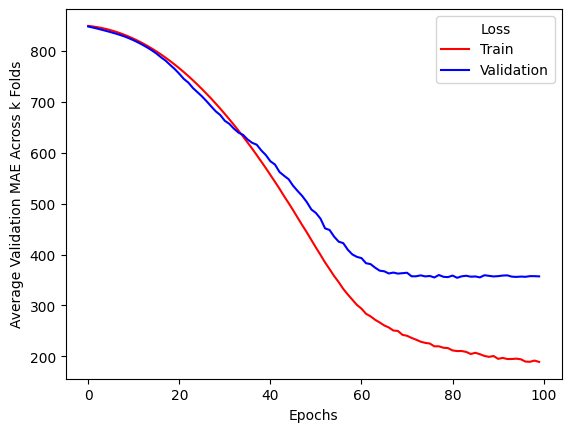

In [83]:
import matplotlib.pyplot as plt

plt.plot(average_train_mae_history, c="r")
plt.plot(average_val_mae_history,c="b")
plt.legend(['Train','Validation'],title="Loss")
plt.xlabel("Epochs")
plt.ylabel("Average Validation MAE Across k Folds")
plt.show()

#*Choose Final Configuration and Produce That Model Here:*

In [84]:
model = build_model()
model.fit(predictors,labels,epochs=70, batch_size=64)

Epoch 1/70
141/141 [==============================] - 3s 5ms/step - loss: 848.9434 - mse: 2677202.7500
Epoch 2/70
141/141 [==============================] - 1s 5ms/step - loss: 846.2602 - mse: 2672842.5000
Epoch 3/70
141/141 [==============================] - 1s 5ms/step - loss: 842.2664 - mse: 2666205.0000
Epoch 4/70
141/141 [==============================] - 1s 5ms/step - loss: 836.9739 - mse: 2657420.5000
Epoch 5/70
141/141 [==============================] - 1s 5ms/step - loss: 830.3907 - mse: 2646656.5000
Epoch 6/70
141/141 [==============================] - 1s 5ms/step - loss: 822.5193 - mse: 2633782.7500
Epoch 7/70
141/141 [==============================] - 1s 5ms/step - loss: 813.3624 - mse: 2618956.2500
Epoch 8/70
141/141 [==============================] - 1s 5ms/step - loss: 802.9222 - mse: 2602313.2500
Epoch 9/70
141/141 [==============================] - 1s 5ms/step - loss: 791.2021 - mse: 2583539.0000
Epoch 10/70
141/141 [==============================] - 1s 5ms/step - loss

Here's what the resulting model looks like.

In [72]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_46 (Dense)            (None, 64)                189120    
                                                                 
 batch_normalization_34 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_47 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_35 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 dense_48 (Dense)            (None, 1)               

#*Final Evaluation*

Don't modify this section; this is the code we will use to evaluate that your model is output properly and that it can generate predictions on new test observations it has never seen before. If your model breaks when I feed it the new data, I will deduct marks, so please ensure that your data pre-processing function works properly!

In [85]:
from google.colab import files
import io

# I'm going to upload my holdout dataset (same set of features)
uploaded = files.upload()
bluebike_holdout = pd.read_csv(io.BytesIO(uploaded['bluebikes_holdout.csv']))

# I'm then going to pre-process it using your commands.
holdout_predictors, holdout_labels = processData(bluebike_holdout)

# Then I'm going to evaluate your model's performance on that data.
loss_metrics = model.evaluate(holdout_predictors,holdout_labels,verbose=1)

Saving bluebikes_holdout.csv to bluebikes_holdout (4).csv
64/64 [==============================] - 0s 3ms/step - loss: 54.9920 - mse: 6224.6855
